# Supervised Learning: Regression algorithms

by Paul and Konstantinos

## Review
What are we trying to do? We're trying to predict a set of continuous values from a training set. One way to do this is by interpolation. In the following figure we can see a set of data points (squares) and splines (blue dashed lines).  The other line and the grey region are the result from Gaussian processes and Kriging that we will be discussing.

<img src="kriging.png", width=600 /img>

What if you want information about the uncertainties or want to do this in an arbitrary number of dimensions? 



## Gaussian Processes: A Lazy Learning Technique

One convenient way of doing both of these things above is by modeling the dataset with a technique called Gaussian processes.  Gaussian processes creates an arbitrary number (any number allowed in principle) of Gaussians and links them via a covariance matrix (how well the Gaussians are correlated).  The covariance matrix defines the *shape* and *correlation length* of the multivariate distribution.  So, how exactly are the Gaussians correlated?

### "Kernel trick"

The covariance matrix requires an input kernel that can take a large number of different forms.  We have listed one very common and relatively simple to understand example, the squared exponential:

$$K_{SE}(x, x') = exp\left(-\frac{\vert\vert x - x'\vert\vert^2}{2l^2}\right)$$

where $x$ and $x'$ are any points (will be points in the training set) and $l$ is the characteristic length-scale of the process (i.e., "how close" every two points $x$ and $x'$ have to be to influence each other significantly).  The starting (prior) distribution in the figure below is created by drawing correlated Gaussian random variables with a mean of 0 (though the starting point could be specified differently if you have a reason to do so from your data) and covariance given by the kernel (given the correlation length).

<img src="prior.png", width=800 /img>

### Learning from training set
Then, you incorporate the training points to rein in the set of possible functions (e.g. number of Gaussians and their parameters). How do you determine the optimal answer? Meh, you optimize the likelihood function below, derived after just about *4 pages of algerbra*:

$$ \log p(f(x)|\theta,x) =  -\frac{1}{2}f(x)^T K(\theta,x,x')^{-1} f(x) -\frac 1 2 \log \det(K(\theta,x,x')) - \frac{|x|} 2 \log 2\pi $$

where $K(\theta ,x,x')$ is the covariance matrix between all possible pairs $(x,x')$ for a given set of hyperparameters $\theta$ in $f(x)\sim N(0,K(\theta ,x,x'))$, a zero-mean distribution. Yeah, sure, whatever...

Why bother showing this technical mess anyway?  ...because this shows you two very useful penality terms:  the first term corresponds to a penalty term for a model's failure to fit observed values and the second term to a penalty term that increases proportionally to a model's complexity.  This is powerful because it is a statistically rigorous way to constrain some hyperparameters automatically (the number of Gaussians)!  This optimization process is called ***Kriging*** named after the scientist that pioneered this technique as a master's student in the 1960s.  Other hyperparameters in the kernel (e.g., correlation length, shape) should be constrained using loss functions, as were discussed briefly last week and will be shown again below in the discussion of cross-validation.

## Gaussian Process Regression example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.utils import split_samples
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import r2_score

%matplotlib inline


# Load data
wds = np.load("SDSS_DR7_WDs.npy")
photo_bands = ['u', 'g', 'r', 'i', 'z']
X = np.column_stack(wds[photo_bands[i]]-wds[photo_bands[i+1]] for i in range(4))
y = wds['Teff']


# take 10% of the data because GPR is slow...
X = X[:len(X) // 10]
y = y[:len(y) // 10]
print "Size of 'X': ", X.shape[0], "x", X.shape[1]
print "Size of 'y': ", len(y)

Size of 'X':  1341 x 4
Size of 'y':  1341


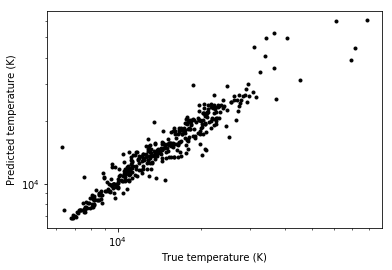

Coefficient of determination: 0.8395812413666416


In [2]:
def do_gpr():
    (X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.7, 0.3], random_state=0)
    gpr = GaussianProcessRegressor(kernel=RBF(length_scale=0.1), normalize_y=True, alpha=1.0)
    gpr.fit(X_train, y_train)
    y_out = gpr.predict(X_test)
    return y_test, y_out


# get test y-value and predicted ones
y_test, y_out = do_gpr()


plt.figure()
plt.loglog(y_test, y_out, "k.")
plt.xlabel("True temperature (K)")
plt.ylabel("Predicted temperature (K)")
plt.show()

print "Coefficient of determination:", r2_score(y_test, y_out)

### Pros
* Good when you want to take small datasets and generalizing them with little a priori information, known or conjectured.
* You can input uncertainties in your training set
* It always returns uncertainties
* Versatile: all sorts of Kernels
 
### Cons
* Computational cost $O(N^3)$

## Under/overfitting and cross-validation

### Underfitting

Underfitting is easily spotted, either by just plotting or using a statistic. For example, the chi-square statistic or the coefficient of determination can report "badness of fit".

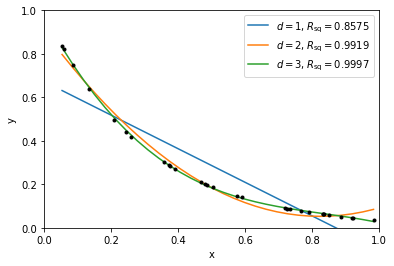

In [3]:
n = 30
x = np.random.rand(n)
y = np.exp(-x / 0.3)

plt.figure()
for deg in range(1, 4):
    model = np.polyfit(x, y, deg)
    y_pred = np.polyval(model, x)
    rsq = r2_score(y, y_pred)
    
    x_plot = np.linspace(min(x), max(x), 30)
    y_plot = np.polyval(model, x_plot)
    plt.plot(x_plot, y_plot, label=r"$d = {}, R_{{\mathrm{{sq}}}} = {:.4f}$".format(deg, rsq))

plt.plot(x, y, "k.")
plt.axis([0, 1, 0, 1])
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


## Overfitting
...but increasing the complexity of a model usually results into a better fit. Can we overdo it? Remember *Occam's razor*.

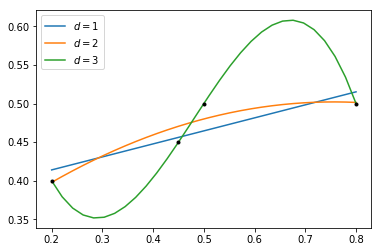

In [4]:
x = np.array([0.2, 0.45, 0.5, 0.8])
y = np.array([0.4, 0.45, 0.5, 0.5])
x_plot = np.linspace(min(x), max(x), 30)

plt.figure()
for deg in range(1, len(x)):
    y_plot = np.polyval(np.polyfit(x, y, deg), x_plot)
    plt.plot(x_plot, y_plot, label=r"$d = {}$".format(deg))

plt.plot(x, y, "k.")
#plt.axis([0, 1, 0, 1])
plt.legend()
plt.show()

## Leave-one-out cross-validation

For d = 1 squared differences = [2.27285019e-03 6.94444444e-05 2.23234576e-03 5.03642040e-03]
For d = 2 squared differences = [0.17163265 0.0016223  0.00171633 0.3364    ]


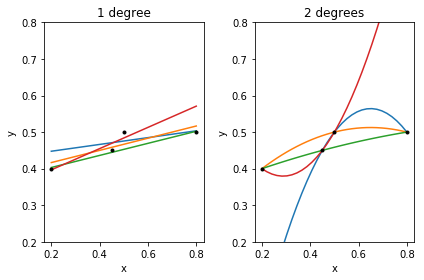

In [5]:
plt.figure()
for deg in [1, 2]:
    diffs = []
    plt.subplot(120 + deg)
    for i in range(len(x)):
        x_sub = np.delete(x, i)
        y_sub = np.delete(y, i)
        model = np.polyfit(x_sub, y_sub, deg)
        y_plot = np.polyval(model, x_plot)
        difference = (np.polyval(model, x[i]) - y[i]) ** 2.0
        diffs.append(difference)
        plt.plot(x_plot, y_plot, "-")
    print "For d =", deg, "squared differences =", np.array(diffs)
    plt.plot(x, y, "k.")
    plt.title("{} degree{}".format(deg, "" if deg == 1 else "s"))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim([0.2, 0.8])

plt.tight_layout()
plt.show()


Thus, by excluding some data points from the fitting process, we allow them to evaluate the goodness of fit without the risk of under/over-fitting.

## Optimal number of neighbors: cross-validation
In previous weeks we saw $k$-nearest neighbors algorithm for classification and regression. **Selecting $k$** was a central question that we answered by studying the dependence of:
* completeness and contamination (classification)
* loss functions (regression)

on $k$. Let's run last week's code for regression.

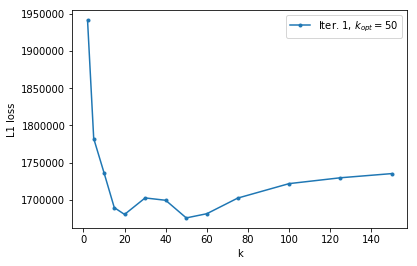

In [6]:
from sklearn import neighbors

# Load data
wds = np.load("SDSS_DR7_WDs.npy")
photo_bands = ['u', 'g', 'r', 'i', 'z']
X = np.column_stack(wds[photo_bands[i]]-wds[photo_bands[i+1]] for i in range(4))
y = wds['Teff']


def calc_loss(x_obs, x_pre):
    """Calculate L1 loss function."""
    return np.sum(np.abs(x_obs - x_pre))


def study_k(iterations=1):
    """Split data to training and test sets, perform kNN regression and plot loss
    function for various k. Repeat the procedure as many times as 'iterations'."""
    plt.figure()
    for i in range(iterations):
        (X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.9, 0.1], random_state=i)

        losses = []
        n_neighbors = np.array([2, 5, 10, 15, 20, 30, 40, 50, 60, 75, 100, 125, 150])
        for k in n_neighbors:
            knn = neighbors.KNeighborsRegressor(k, weights='uniform')
            knn.fit(X_train, y_train)
            y_out = knn.predict(X_test)
            losses.append(calc_loss(y_test, y_out))

        k_opt = n_neighbors[np.argmin(losses)]
        plt.plot(n_neighbors, losses, marker='.', linestyle='-', label="Iter. {}, $k_{{opt}} = {}$".format(i + 1, k_opt))
        plt.xlabel("k")
        plt.ylabel("L1 loss")
    #if iterations > 1:
    plt.legend()
    plt.show()


study_k()

We see two local minima, with similar evalutations of the loss function, for $k=20$ and $k=50$. What is the cause?
*The distribution of our data* or *a stochastic effect* during the cross-validation?

If this a stochastic effect, we would notice different values of optimal $k$ for different choices of training and test sets. The following command repeats the loss vs $k$ study for different splitting of the data.

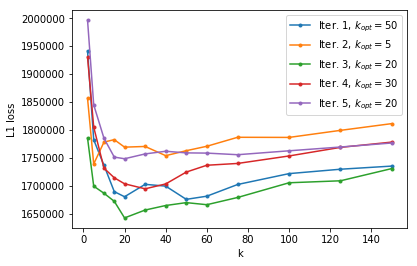

In [7]:
study_k(5)

### Using separate cross-validation and test sets

In the previous weeks, we used the term *test set* even when we were *manually optimizing* for the hyperparameter ($k$ in nearest-neighbors, or bandwidth in Gaussian processes, etc.). **We will call *cross-validation* set, the set we use to optimize the hyperparameters**. The **test set** is the one we use to evaluate our *classifier* or *regressor* after all investigations in the data (training, optimizing for hyperparameters, etc.)

Step-by-step:

1. Training set between 50% and 70% of the data
2. The rest is **equally split** into cross-validation and test set
3. We use the cross-validation set to search for the optimal hypermeter(s)
4. After deciding the hyperparameter(s) (and the corresponding parameters of the model, if any), we use the test data to evaluate the quality of our regression (or classification) scheme

Let's try the above steps in our photometric data. Remember that the *loss function* is used to evaluate the goodness-of-fit. For a classifier we could use *contamination* and/or *completeness* or any other statistic serves our purpose. Consequently, the same statistic is used to evaluate the performance of the overall scheme (hyperparameter and parameters).

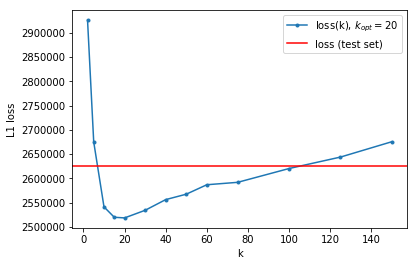

In [8]:
(X_train, X_cross, X_test), (y_train, y_cross, y_test) = split_samples(X, y, [0.7, 0.15, 0.15], random_state=0)

losses = []
n_neighbors = np.array([2, 5, 10, 15, 20, 30, 40, 50, 60, 75, 100, 125, 150])
for k in n_neighbors:
    knn = neighbors.KNeighborsRegressor(k, weights='uniform')
    knn.fit(X_train, y_train)
    y_out = knn.predict(X_cross)
    losses.append(calc_loss(y_cross, y_out))

k_opt = n_neighbors[np.argmin(losses)]
plt.plot(n_neighbors, losses, marker='.', linestyle='-', label="loss(k), $k_{{opt}} = {}$".format(k_opt))

y_out = knn.predict(X_test)
final_loss = calc_loss(y_test, y_out)
plt.axhline(final_loss, color="r", label="loss (test set)")
plt.legend()
plt.xlabel("k")
plt.ylabel("L1 loss")
plt.show()

## References
[1] sklearn: http://scikit-learn.org/stable/supervised_learning.html

[2] astroML: http://www.astroml.org/book_figures/chapter8/index.html

[3] Gaussian Processes: http://katbailey.github.io/post/gaussian-processes-for-dummies/

[4] Wiki: https://en.wikipedia.org/wiki/Gaussian_process